In [8]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from uncertainties import ufloat


def selectStart(t, V):
    s = 0
    count = 0
    for i, vol in enumerate(V):
        s += vol
        count += 1
        if s / count - vol > 0.4:
            return i

    return 0


def fit(t, V0, tau, c):
    return V0 * np.exp(-t / tau) + c



FILE 28
V0 =  10, tau =  4.697e-06, c = -3
(4.697+/-0.005)e-06

FILE 29
V0 =  10, tau =  8.749e-06, c = -2.8
(8.749+/-0.006)e-06

FILE 30
V0 =  9.6, tau =  1.298e-05, c = -2.7
(1.2979+/-0.0009)e-05

FILE 31
V0 =  9.2, tau =  1.653e-05, c = -2.5
(1.6533+/-0.0010)e-05

FILE 32
V0 =  9.2, tau =  1.765e-05, c = -2.5
(1.7648+/-0.0011)e-05

FILE 33
V0 =  9.5, tau =  1.373e-05, c = -2.7
(1.3727+/-0.0009)e-05

FILE 34
V0 =  9.9, tau =  9.335e-06, c = -2.9
(9.335+/-0.007)e-06

FILE 35
V0 =  10, tau =  4.989e-06, c = -3.1
(4.989+/-0.005)e-06


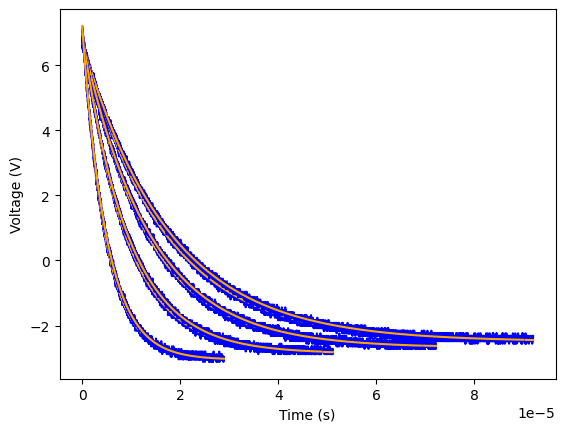

In [62]:
files = [28, 29, 30, 31, 32, 33, 34, 35]
taus = []
for f in files:
    print(f"\nFILE {f}")
    name = f"./data/DS00{f}.CSV"
    t, V = np.transpose(np.loadtxt(name, skiprows=16, delimiter=",", usecols=(0, 1)))

    start = selectStart(t, V)
    end = np.where(V == V.min())[0][0]
    V = V[start:end]
    t = t[start:end]
    t = np.linspace(0, t[-1] - t[0], len(V))
    a, cov = curve_fit(fit, t, V, p0=(6, 0.03, -2))

    plt.plot(t, V, c="blue")
    plt.plot(t, fit(t, *a), "orange")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    print(f"V0 = {a[0] : .2g}, tau = {a[1] : .4g}, c = {a[2] : .2g}")
    tau = ufloat(a[1], np.sqrt(np.diag(cov))[1])
    taus.append(tau)
    print(tau)


# No Capacitor Present

In [28]:
def linear(x, a, b):
    return a * x + b


Parasitic Capacitance:  16.1+-0.3 pF


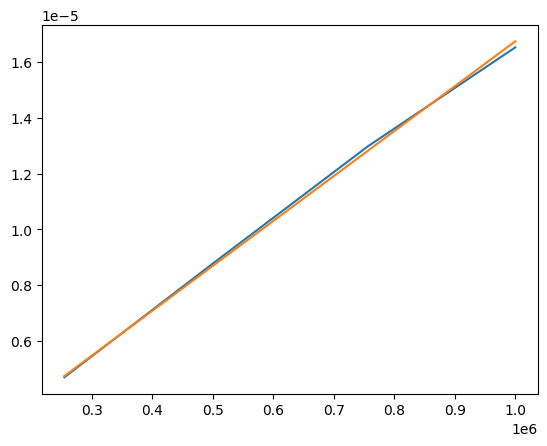

In [55]:
Ts = taus[0:4]
Tn = list(map(lambda x: x.n, Ts))
Rs = np.array([254.3e3, 498e3, 756e3, 1000e3])  # kohm
plt.plot(Rs, Tn)

a, cov = curve_fit(linear, Rs, Tn, sigma=list(map(lambda x: x.s, Ts)))
err = np.sqrt(np.diag(cov))[0]
plt.plot(Rs, linear(Rs, *a))
print(
    f"Parasitic Capacitance: {a[0] *1e12: .4g}+-{np.sqrt(np.diag(cov))[0]*1e12:.2g} pF"
)
withoutC = ufloat(a[0], err)


Capacitance with Capacitor:  17.15+-0.26 pF


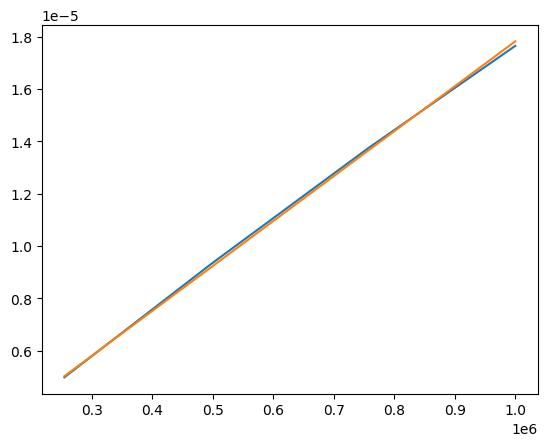

In [56]:
Ts = taus[4:8][::-1]
Tn = list(map(lambda x: x.n, Ts))
Rs = np.array([254.3e3, 498e3, 756e3, 1000e3])  # kohm
plt.plot(Rs, Tn)

a, cov = curve_fit(linear, Rs, Tn, sigma=list(map(lambda x: x.s, Ts)))
plt.plot(Rs, linear(Rs, *a))
err = np.sqrt(np.diag(cov))[0]
print(f"Capacitance with Capacitor: {a[0] *1e12: .4g}+-{err*1e12:.2g} pF")
withC = ufloat(a[0], err)


In [58]:
print((withC.n - withoutC.n) * 10**12)
print((withC - withoutC).s * 10**12)
print(withC - withoutC)


1.048178472342238
0.39480869861443807
(1.0+/-0.4)e-12
